# Homework: Autoencoding MNIST and Celebrity Faces

> **Due Date: May 21st, 2021 @ 10:00am (before class)**
> 
> Please turn in this completed notebook to lponzoni@keiserlab.org.

**Collaboration policy and more** 

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.cs.toronto.edu/~hinton/science.pdf) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.


## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.cs.toronto.edu/~hinton/science.pdf), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data** 

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [1]:
"""
# Skip this cell if running locally
from google.colab import drive
drive.mount('/content/gdrive')
"""

"\n# Skip this cell if running locally\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\n"

In [2]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

You shouldn't need CUDA for this assignment, but if you want a head start, or if you just want to see the difference between using a CPU versus a GPU, set `use_cuda = True` below. 
You can check if CUDA is available on your computer with: `torch.cuda.is_available()`

If you are working on Colab, make sure to activate the GPU ("Runtime" -> "Change runtime type...").

In [3]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
torch.manual_seed(7);

> **Question 0.1) Why is it important to set the seed for the random number generator?**

*Double-click to add your answer...*
Setting the random seed ensures reproducible results across devices.



### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [5]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi219_downloads', train=True, download=True,
    transform=preprocessing)
                               
test_dataset = datasets.MNIST(
    './bmi219_downloads', train=False, download=True, 
    transform=preprocessing)

print(type(train_dataset))

<class 'torchvision.datasets.mnist.MNIST'>


In [6]:
%%bash
ls -lah bmi219_downloads/MNIST/raw
head bmi219_downloads/MNIST/raw/t10k-images-idx3-ubyte

total 131200
drwxr-xr-x  10 ajipalar  staff   320B May 19 16:38 .
drwxr-xr-x   4 ajipalar  staff   128B May 19 16:32 ..
-rw-r--r--   1 ajipalar  staff   7.5M May 19 16:38 t10k-images-idx3-ubyte
-rw-r--r--   1 ajipalar  staff   1.6M May 19 16:38 t10k-images-idx3-ubyte.gz
-rw-r--r--   1 ajipalar  staff   9.8K May 19 16:38 t10k-labels-idx1-ubyte
-rw-r--r--   1 ajipalar  staff   4.4K May 19 16:38 t10k-labels-idx1-ubyte.gz
-rw-r--r--   1 ajipalar  staff    45M May 19 16:37 train-images-idx3-ubyte
-rw-r--r--   1 ajipalar  staff   9.5M May 19 16:37 train-images-idx3-ubyte.gz
-rw-r--r--   1 ajipalar  staff    59K May 19 16:37 train-labels-idx1-ubyte
-rw-r--r--   1 ajipalar  staff    28K May 19 16:37 train-labels-idx1-ubyte.gz
    '                                                                                                                                                                                                                T���<$                      �������������ƪ4           

> **Q1.1) How many examples do the training set and test set have?**

Train : 60000 examples
Test  : 10000 examples
...

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**

The input examples are held in a binary ubyte format. Training and test sets are defined in torchvision datasets and loaded into their respective data loaders.
The DataLoader loads in tensors according to the batch size. In this case the tensors have dimension of (batch size, channels, x, y). The batch size is the number of images loaded into the tensor. Grayscale images have a single channel and 28 * 28
pixels in the x and y directions. 
These images must be unraveled into length 784 vector before placeing them through
the fully connected layer
...

> **Q1.3) Why do we normalize the input data for neural networks?**

The feature normalization is done during the compose step of preproccesing the data.
The preporocessing Normalizes the intensity of the pixels in the images and formats them to a tensor - this is passed as an argument to the MNIST dataset.

Feature normalization will help speed up training  because we have a set step size alpha. For any loss function - a small step in one direction may be a large step in another and vice versa. This may prevent the neural network from finding sufficiently useful local minima. 
...

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**

The purpose of the validation and test sets are to prevent over-fitting (memorizing the data). The goal of training a neural net for a scientific applicaiton is for the network to learn generalizable features i.e.

The validation set can be seen as a part of training because an optimal model will train on the training data, and not lose performance on the validation data.

The test data may be used at the very end after training and validation after multiple iterations of training and validaiton. The model and model builder should be blind (as much as possible) to the test data. This is a stronger test of generalizability especially if the test set is dissimiliar to the training and validation sets in some way.

...

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

train_loader
type <class 'list'>
first object:     <class 'torch.Tensor'>
second object: <class 'torch.Tensor'>
tensor shape: torch.Size([64, 1, 28, 28])
len labels : 64
tensor([0, 3, 2, 3, 7, 0, 5, 7, 2, 7, 3, 9, 2, 1, 1, 5, 7, 4, 2, 9, 2, 6, 7, 3,
        4, 1, 8, 6, 2, 3, 3, 1, 6, 0, 5, 9, 9, 1, 3, 9, 2, 7, 5, 2, 8, 4, 9, 4,
        8, 7, 5, 2, 1, 9, 6, 0, 3, 4, 3, 3, 2, 0, 1, 7])
[-0.42421296]


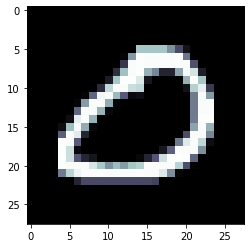

In [7]:

def get_loaders(BATCH_SIZE=8, NUM_WORKERS=4):
    BATCH_SIZE = 64  # <-- Please change this as necessary
    NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=NUM_WORKERS)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=NUM_WORKERS)
    
    return train_loader, test_loader
train_loader, test_loader = get_loaders()
print("train_loader")
print(train_loader)
#The DataLoader object at some memory location

for i in train_loader:
    #Taking the first example
    # Dimension (BATCH_SIZE, , 28, 28)
    # Dimension (Bath_size, channels, x, y)
    tensor = i[0]
    labels = i[1]
    print('type %s\nfirst object: \
    %s\nsecond object: %s' %(type(i),
                          type(i[0]),
                          type(i[1])
                         ))
    
    
    
    
    
    print('tensor shape: %s' %(str(tensor.shape)))
    # Dimension (Bath_size, channels, x, y)
    print("len labels : %s" %(len(labels)))
    print(labels)
    
    a = tensor.numpy()
    plt.imshow(a[0, 0, :, :], cmap='bone')
    print(a[0 , : , 0 , 0])
    break

In [8]:
def min_memory_required(N):
    """
    What is the minimum memory a tensor takes up
    """
    
    batch_size = N #numebr of images
    float_type = 64 #64 bits per pixel
    npixels = 28*28
    dimension2 = 64 #64 bits for dimension 2
    
    return N*(npixels*float_type + dimension2)/8000000 #in mega bytes
    

In [9]:
min_memory_required(1), min_memory_required(60000)

(0.00628, 376.8)

> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**

This could help reduce batch effects, for example the ordering of the data. 
The results of the validation set should be the same no matter the order.
...

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**

The batch size determines the number of images and training labels the model sees at once. A batch size must be small enough to fit into memory including the images and gradients. Empirically I'll try a batch size of 64. 
...
 
> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**

The DataLoader returns a list of tensors. The first tensor contains all the images in the batch. The second tensor contains the labels. 
...

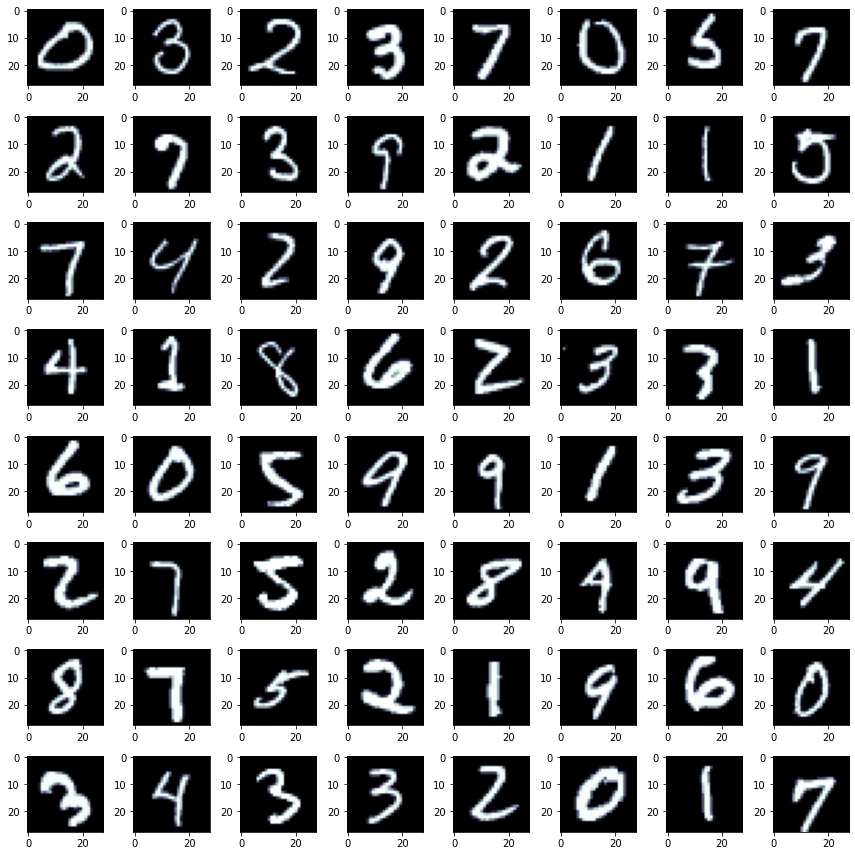

In [10]:
#Helper function to view square batches
def imshow(t, n=None, batch=False, cmap="bone"):
    if batch:
        if n:
            plt.imshow(t[n, 0, :, :].detach().numpy(), cmap=cmap)
        else:
            plt.imshow(t[0, :, :].detach().numpy(), cmap=cmap)
    else:
        plt.imshow(t.detach().numpy(), cmap=cmap)

def batch_show(a, n,cmap="bone"):
    """
    a: a numpy array [batch size, channel, x, y]
    """
    plt.imshow(a[n, 0, :, :], cmap=cmap)
    #imshow(a, n, cmap)

def view_batch(train_loader, tensor, w=12, h=12, cmap="bone"):
    plt.figure(figsize=(w,h))
    bs = train_loader.batch_size
    assert bs % 2 == 0
    sqrt = int(np.sqrt(bs))
    assert bs % sqrt == 0
    a = tensor.detach().numpy()
    #plt.subplot(sqrt, sqrt, 1)
    
    for i in range(sqrt):
        for j in range(1, sqrt+1):
            idx = j + i*sqrt
            plt.subplot(sqrt, sqrt, idx )
            #plt.imshow(a[idx-1, 0, :, :], cmap=cmap)
            batch_show(a, idx-1, cmap=cmap)
    plt.tight_layout()
    plt.show()    

view_batch(train_loader, tensor)

### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[1000 x 500 x 250 x 2 x 250 x 500 x 1000]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encoder()` and a `.decoder()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [11]:
# nn, optim, Dataset, DataLoader

#Loss functions can be found from F
#nn.Module and nn.Parameter can give clearer syntax

#Subclassing nn.Module

#What are the hidden layers?


class HNet(nn.Module):
    """
    28 x 28 images
    Flatten
    784  : Linear - Visible layer
    
    Hidden Layers
    1000 : Logistic
    500  : Logistic
    250  : Logistic
    2    : Code - Linear
    250  : Logistic
    500  : Logistic
    1000 : Logistic
    Hidden Layers end
    784 - visible layer
    28 x 28 Broadcast
    
    """
    def __init__(self):
        super(HNet, self).__init__() #HNet inherits from nn.Module
        ### Implement a version of Hinton's 2006 Autoencoder,
        ### using a bottleneck latent dimension of 2
        self.flatten = nn.Flatten() #flatten the images to vectors
        self.encoder = nn.Sequential(
            #Input Visible
            nn.Linear(28*28, 1000), #default bias=True
            nn.Sigmoid(), #Hidden 1
            nn.Linear(1000, 500),
            nn.Sigmoid(), #Hidden 2
            nn.Linear(500, 250),
            nn.Sigmoid(), #Hidden 3
            nn.Linear(250, 2) #latent / code
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 250), #latent / code
            nn.Sigmoid(), #Hidden 5
            nn.Linear(250, 500),
            nn.Sigmoid(), #Hidden 6
            nn.Linear(500, 1000),
            nn.Sigmoid(), #Hidden 7
            nn.Linear(1000, 784) #Output Visible
        )
 
    def forward(self, x):
        ### Implement the forward pass
        x = self.flatten(x)
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [12]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        ### Fill in your network architecture here
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
    
    def forward(self, x):
        ### Implement the forward pass
        x = self.flatten(x) # 28 x 28 -> 784
        latent = self.encoder(x) # 784 -> 2
        out = self.decoder(latent) # 2 -> 784
        return out
    def encode(self, x):
        x = self.flatten(x)
        return self.encoder(x)
    def decode(self, x):
        return self.decoder(x)


> **Q3.1) What activation functions did you use, and why?**

I used the ReLU function because I was concerend about the vanishing gradient problem encountered because of the derivative of the logistic function. 
...

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**. 
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs). 

A few useful tips: 
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [13]:
def train(train_loader, model, 
          optimizer, 
          criterion, 
          n_epochs=10, prototype=False, 
          record=None, every=None, 
          checkpoints=None, **kwargs):
    """
    prototype (bool) : turns printing on
    record : tuple or none. ()
    """
    model.to(device)
    model.train()
    ### Define your training loop here
    
    ###List to store images
    
    if record:
        out_list = []
    
    if prototype:
        for n in range(n_epochs):
            for batchid, (data, target) in enumerate(train_loader):
                #move the data to the device
                print("data to device")
                print("data type")
                data = data.to(device)
                print(type(data))
                print("data shape %s" %(str(data.shape)))

                #Forget about the label

                #zero the gradients
                optimizer.zero_grad()

                #Tensor [batch_size, 1, 784]
                target = model.flatten(data)
                print("target shape : %s" %(str(target.shape)))
                output = model(data)
                print("output type")
                print(type(output))
                print("output shape %s" %(str(output.shape)))
                
                #compute the loss
                loss = criterion(output, target)
                print("loss shape : %s" %(str(loss.shape)))
                print("loss : %s" %(loss))
                
                #back propagation
                loss.backward()
                
                #update the gradients
                optimizer.step()
                break
    else:
        if record and prototype:
            print("epoch  iter  loss")
        for n in range(n_epochs):
            if checkpoints and (n in checkpoints):
                path = "MyNet_epoch_%s" %(n)
                print("Checkpoint %s" %(path))
                torch.save(model.state_dict(), path)
            for batchid, (data, target) in enumerate(train_loader):
                #move the data to the device
                
                data = data.to(device)

                #zero the gradients
                optimizer.zero_grad()

                #Tensor [batch_size, 1, 784]
                target = model.flatten(data)
                
                output = model(data)
                
                #compute the loss
                loss = criterion(output, target)
                
                
                #back propagation
                loss.backward()
                
                #update the gradients
                optimizer.step()
                
                if record and (batchid % every == 0):
                    item = loss.item()
                    if prototype:
                        print("%s     %s      %s" %(n, batchid, item))
                    out_list.append((n, batchid, item))
    
    if record:
        return out_list
                
        

In [14]:
# What are the effects of different batch sizes?
def test_batch_size(bs=64):
    train_loader, test_loader = get_loaders(BATCH_SIZE=bs)
    #Define a model
    model = MyNet()
    #Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = F.mse_loss

    #Train the model
    out_list = train(train_loader, 
                     model, optimizer, 
                     criterion, n_epochs=10, prototype=False,
                     record=True, every=99)
    return model, out_list

In [15]:
def plot_loss(output_list, prototype=False):
    y = np.array(output_list)
    y = y[:, 2]
    if prototype:
        print(y.shape)
    x = np.linspace(0,len(y), len(y))
    if prototype:
        print(x.shape)
    plt.scatter(x,y)
    plt.xlabel("Save point")
    plt.ylabel("loss")
    plt.show()
 

In [16]:
   
def test_six_batch_sizes(l,w):
    plt.figure(figsize=(l,w))
    plt.tight_layout()
    plt.suptitle("Batch sizes")
    sizes = [1, 8, 64, 512, 1024, 4096]
    for i, size in enumerate(sizes):
        print("Training batch %s" %(size))
        model, olist = test_batch_size(bs=size)
        plt.subplot(2, 3, i+1)
        plt.title("Batch size %s" %(size))
        plot_loss(olist)
    plt.show()

#test_six_batch_sizes(12,12)


### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

> **Q5.1) What loss function is suited to this problem?**

This is a regression, not a classificaiton because the images are grayscale.
I used mean squared error
...

> **Q5.2) Try a few optimizers, what seemed to work best?**

Stochastic gradient descent seems to work well.
...

> **Q5.3) What's the effect of choosing different batch sizes?**

Six batch sizes were tested [1, 8, 64, 512, 1024, 4096] at a learning rate of 0.01
using stochasitc gradient descent on MyNet. Training on very larger batches seems to take longer. The loss curves appear similiar though not identicle
...

In [17]:
#Define model, optimizer and criteria
model = MyNet()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
criterion = F.mse_loss

#Train the model
out_list = train(train_loader, 
                 model, optimizer, 
                 criterion, n_epochs=1, prototype=False,
                 record=True, every=99)


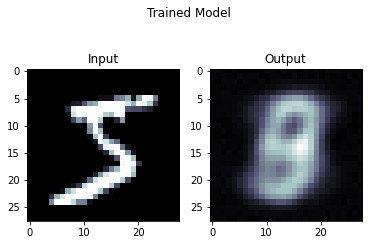

In [18]:
#Helper funciton to plot the input and the output
def plot_pairs(t1, t2, title1="Input", title2="Output"):
    plt.subplot(121)
    plt.title(title1)
    imshow(t1)
    plt.subplot(122)
    plt.title(title2)
    imshow(t2)
    

#Plot the input and output of the trained model
d = train_dataset[0][0]
o = model(d)
o = torch.reshape(o, (28, 28))
plt.suptitle("Trained Model")
plot_pairs(d[0,:,:], o)

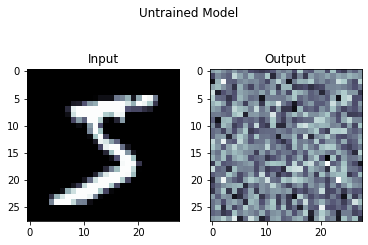

In [19]:
#Plot the input and the output of the untrained model
untrained = MyNet()
o = untrained(d)
o = torch.reshape(o, (28, 28))
plt.suptitle("Untrained Model")
plot_pairs(d[0,:,:], o)

### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [20]:
### Set a number of training epochs and train your model.
checkpoints = [0, 5, 30, 60, 90]
#checkpoints = [0, 4]
batch_size = 1
train_loader, test_loader = get_loaders(batch_size)
model = MyNet()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
criterion = F.mse_loss
out_list = train(train_loader, 
                 model, optimizer, 
                 criterion, n_epochs=99, prototype=False,
                 record=True, every=99, checkpoints=checkpoints)


Checkpoint MyNet_epoch_0
Checkpoint MyNet_epoch_5
Checkpoint MyNet_epoch_30
Checkpoint MyNet_epoch_60
Checkpoint MyNet_epoch_90


In [21]:
"""
n=90
path = "MyNet_epoch_end%s" %(n)
print("Checkpoint %s" %(path))
torch.save(model.state_dict(), path)
"""

'\nn=90\npath = "MyNet_epoch_end%s" %(n)\nprint("Checkpoint %s" %(path))\ntorch.save(model.state_dict(), path)\n'

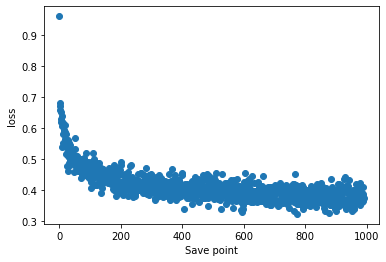

In [22]:
plot_loss(out_list)

In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

Text(0, 0.5, 'MSE')

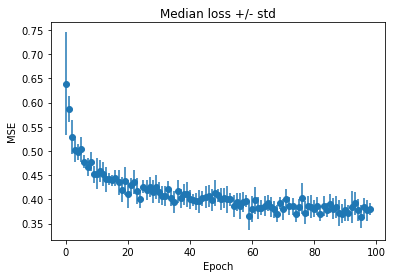

In [23]:
### Plot loss curve using Matplotlib
import pandas as pd
a = np.array(out_list)
d = pd.DataFrame(a, columns=['Epoch', 'iter', 'mse_loss'])
epochs = list(set(d['Epoch']))
mean_mse_loss = []
sd_mse_loss = []
for epoch in epochs:
    temp = d[d['Epoch']==epoch]
    mean_mse_loss.append(np.median(temp['mse_loss']))
    sd_mse_loss.append(np.std(temp['mse_loss']))


plt.errorbar(epochs, mean_mse_loss,
             yerr=sd_mse_loss,
            fmt='o')
plt.title("Median loss +/- std")
plt.xlabel("Epoch")
plt.ylabel("MSE")



> **Q6.1)  How do you know when your network is done training?**

... The loss function should have a minimal value in the training set and the test set. If the value goes up for the test set this indicates overfitting.



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do. 

In [24]:
# extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(6, mini_batch.shape[0])
examples = mini_batch[:n_examples]

# compute reconstructions
with torch.no_grad():
    reconstr_examples = model.forward(
        examples.view(n_examples, -1).to(device))

# save image with original v. reconstructed images
comparison = torch.cat([
    examples,
    reconstr_examples.view(-1, 1, 28, 28).cpu()])
save_image(comparison.cpu(), 'training_reconstruction.png', nrow=n_examples)

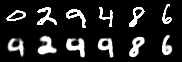

In [25]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

torch.no_grad() prevents the gradients from being updated, which is undesired when applying the model
...

### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


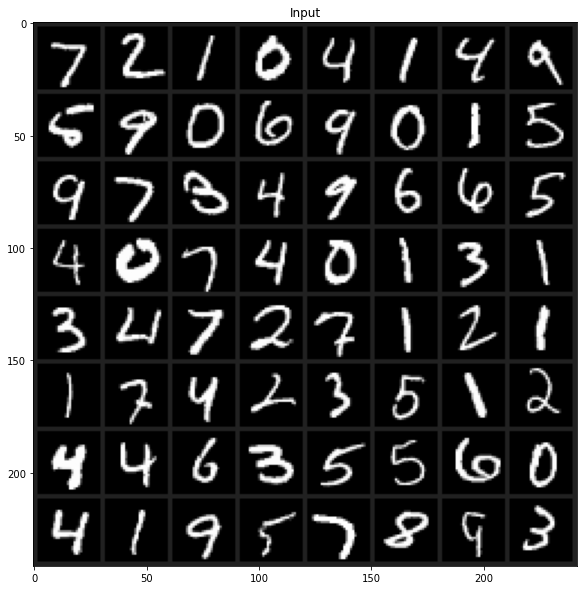

In [26]:
### Helper Functions for Plotting Multiple Images

def imshow(inp, 
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.005)  # pause a bit so that plots are updated
    
def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch

out = torchvision.utils.make_grid(batch)
imshow(out, title="Input")


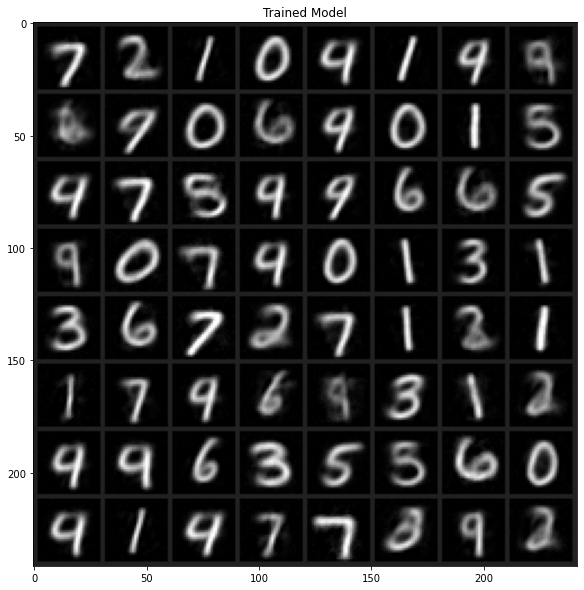

In [27]:
#Plot the reconstruction
out = reconstructions_from_batch(model, batch)
out = torchvision.utils.make_grid(out)
imshow(out, title="Trained Model")

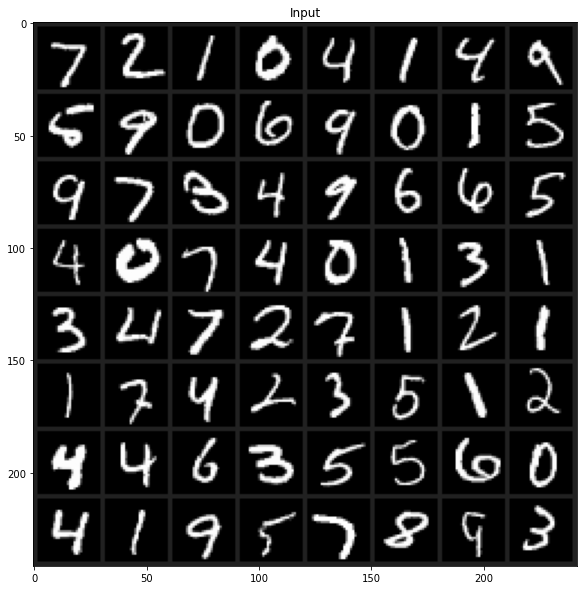

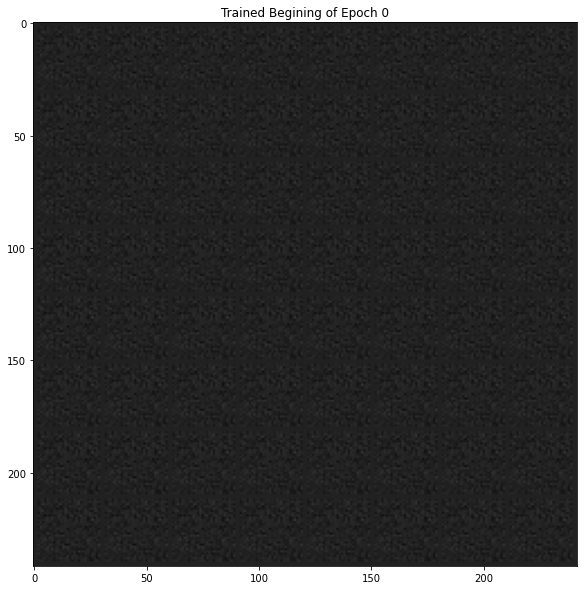

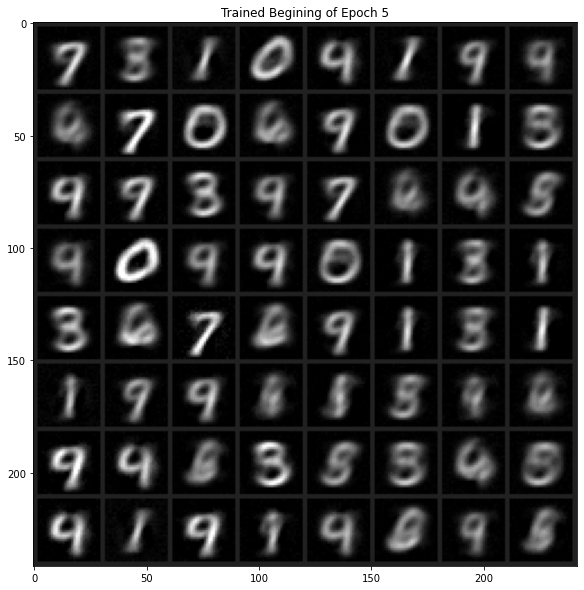

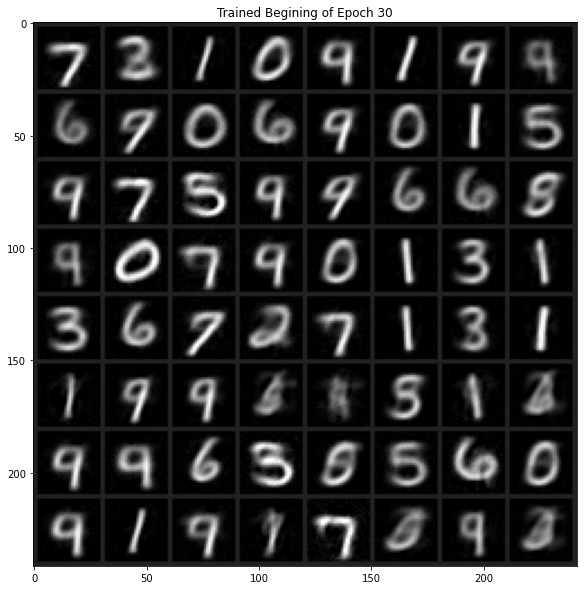

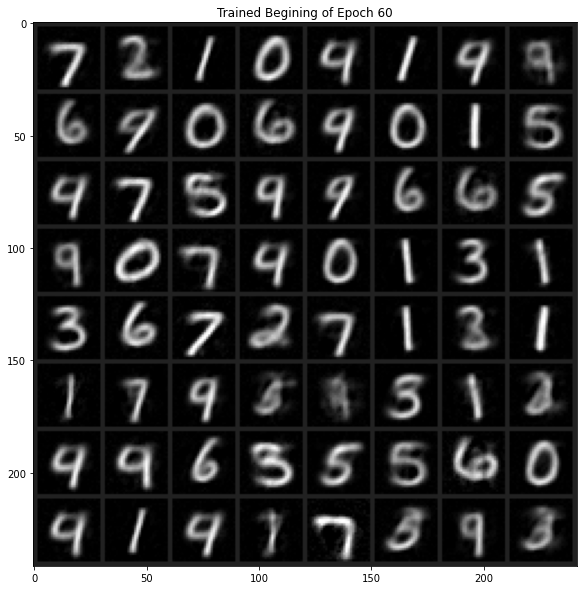

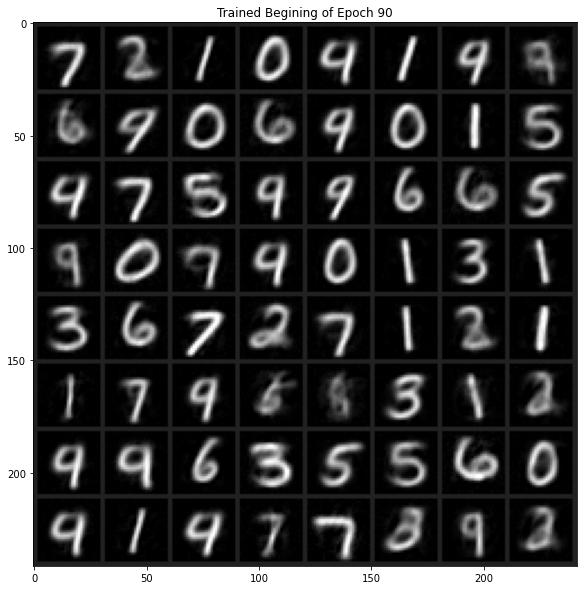

In [28]:
### Iterate over checkpoints and plot reconstruction 
### figures from the test set.

def plot_checkpoints(checkpoints, test_loader):
    # Get a batch of training data
    batch, classes = next(iter(test_loader))

    # Make a grid from batch

    out = torchvision.utils.make_grid(batch)
    imshow(out, title="Input")
    for ch in checkpoints:
        path = "MyNet_epoch_%s" %(ch)
        model = MyNet()
        model.load_state_dict(torch.load(path))
        
        out = reconstructions_from_batch(model, batch)
        out = torchvision.utils.make_grid(out)
        imshow(out, title="Trained Begining of Epoch %s" %(ch))
        
plot_checkpoints(checkpoints, test_loader)

### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space. 
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**. 


In [29]:
%%bash
ls

AjiPalar_bmi219_proposal.docx
Homework_MNIST_Autoencoder.ipynb
Homework_MNIST_Autoencoder_copy.ipynb
MyNet_epoch_0
MyNet_epoch_30
MyNet_epoch_4
MyNet_epoch_5
MyNet_epoch_60
MyNet_epoch_90
MyNet_epoch_end90
README.md
autograd_tutorial.ipynb
bmi219_downloads
class-notes.org
course-documents
custom nn modules.ipynb
data
env
pytorch_auto_grad.ipynb
pytorch_example.ipynb
runs
src
tensor_board_tutorial.ipynb
training_reconstruction.png
utilities
~$iPalar_bmi219_proposal.docx


In [30]:
### Write a helper function to grab examples from the test_loader to generate
### pairs of embeddings and their associated labels

def encode(model, device, test_loader):
    #### Fill this in! ####
    model.to(device)
    x_latent = []
    y_latent = [] # get the latent embeddings, which will ultimately be a vector of x, y coordinates
    labels = []  # this should match the dim of latent_embeddings, so each pair of coordinates has an associated label
    for i, (data, label) in enumerate(test_loader):
        #print(data.shape)
        data.to(device)
        with torch.no_grad():
            # batchsize x 2 tensor
            latent = model.encode(data)
            for j, t in enumerate(latent):
                x_latent.append(float(t[0]))
                y_latent.append(float(t[1]))
                labels.append(int(label[j]))
    return x_latent, y_latent, labels

def plot_latent(n):
    path = "MyNet_epoch_%s" %(n)
    model = MyNet()
    model.load_state_dict(torch.load(path))
    
    ### Plot latent space representation color-coded 
    ### according to their "true" labels
    
    x, y, l = encode(model, device, test_loader)
    colors = {0:'red', 1:'blue', 2:'yellow',
             3:'green', 4:'purple', 5:'black',
             6:'orange', 7:'grey', 8:'DarkBlue',
             9:'violet'}
    c = []
    for lbl in l:
        clr = colors[lbl]
        c.append(clr)
    latent = pd.DataFrame({'x':x, 'y':y, 'l':l, 'color':c})

    latent.plot.scatter('x','y',c='color', 
                        title="Latent space epoch %s" %(n)
                        )
    plt.show()


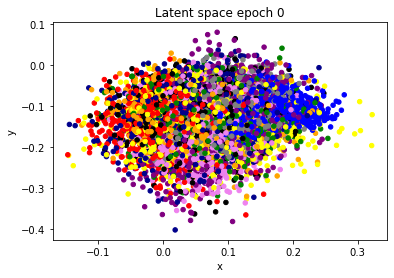

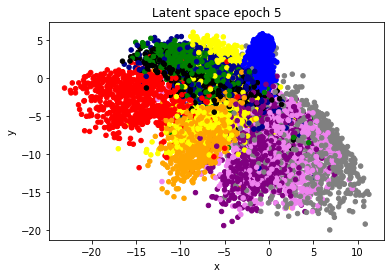

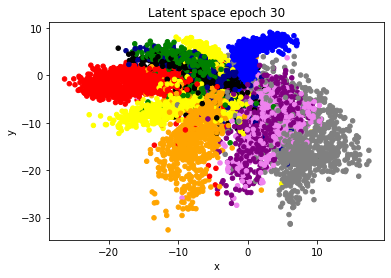

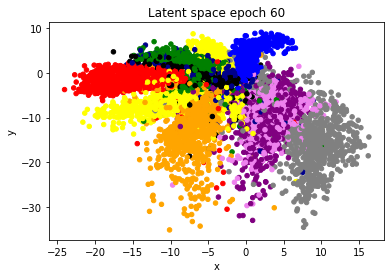

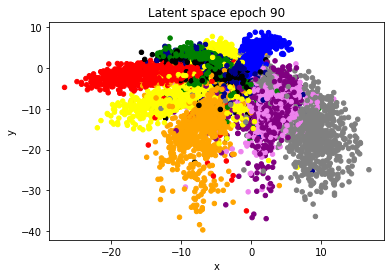

In [31]:
for i in checkpoints:
    plot_latent(i)

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**
   colors = {0:'red', 1:'blue', 2:'yellow',
             3:'green', 4:'purple', 5:'black',
             6:'orange', 7:'grey', 8:'DarkBlue',
             9:'violet'}

I expected 7's (grey) to be close to ones (blue). The are distinguishable.
Fives are very hard to distinguish, overlapping with three's, zero's, two's
Sixes are well distinguished and are far apart from sevens and zero's.
Sixes are somewhat close to violet and overlapping with twos
...

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [32]:
### Download faces.zip and unzip it into bmi219_downloads/

In [33]:
preprocessing = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4401,), (0.2407,)),
])

train_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/train',
    transform=preprocessing)

test_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/test',
    transform=preprocessing)

FileNotFoundError: [Errno 2] No such file or directory: 'bmi219_downloads/Faces/train'

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?